In [1]:
!pip install matplotlib
!pip install pytorchcv
!pip install scikit-learn
!pip install torch torchvision
!pip install scikit-image
!pip install timm
!pip install matplotlib-venn
!pip install opencv-python
!pip install torchcam

In [2]:
import numpy as np
print(np.__version__)


1.26.4


In [3]:
import os
import random
import re
import torch
import cv2
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure
from torchvision import transforms, datasets, models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import shutil
import zipfile
import glob
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split,Dataset
from pytorchcv.model_provider import get_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
import seaborn as sns
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from torchcam.methods import SmoothGradCAMpp  
from torchvision import transforms


In [4]:
# current working directory
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /home/ec2-user/Research_Project


# BreakHis (Training Dataset)

In [5]:


def sample_img(class_name, num_samples=3):
    base_dir = "/home/ec2-user/Research_Project/BreakHis/Dataset"
    class_dir = os.path.join(base_dir, class_name)
    
    image_files = [
        os.path.join(class_dir, file)
        for file in os.listdir(class_dir)
        if file.lower().endswith((".png", ".jpg", ".jpeg"))
    ]
    
    if not image_files:
        print(f"No images found in {class_dir}.")
        return
    
    sample_images = random.sample(image_files, min(num_samples, len(image_files)))
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
    
    if len(sample_images) == 1:
        axes = [axes]
    
    for ax, img_path in zip(axes, sample_images):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(os.path.basename(img_path))
    
    plt.suptitle(f"Sample Images from '{class_name}' in BreakHis dataset")
    plt.show()


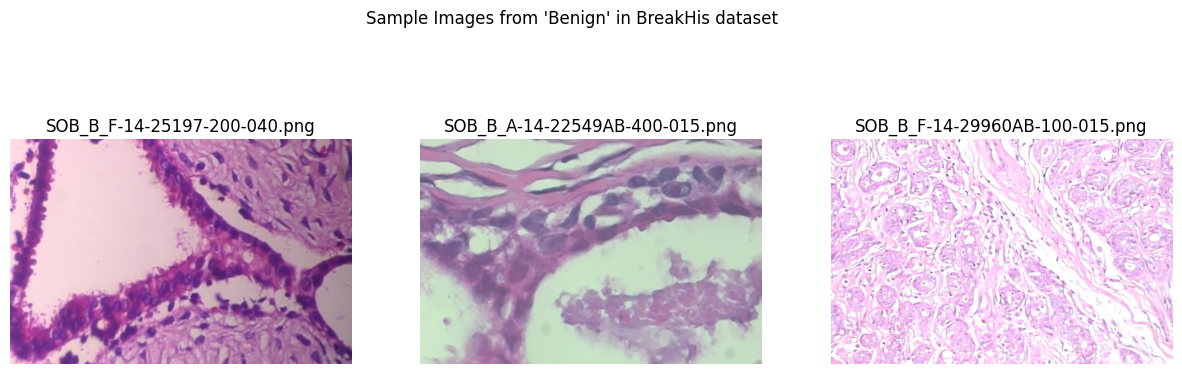

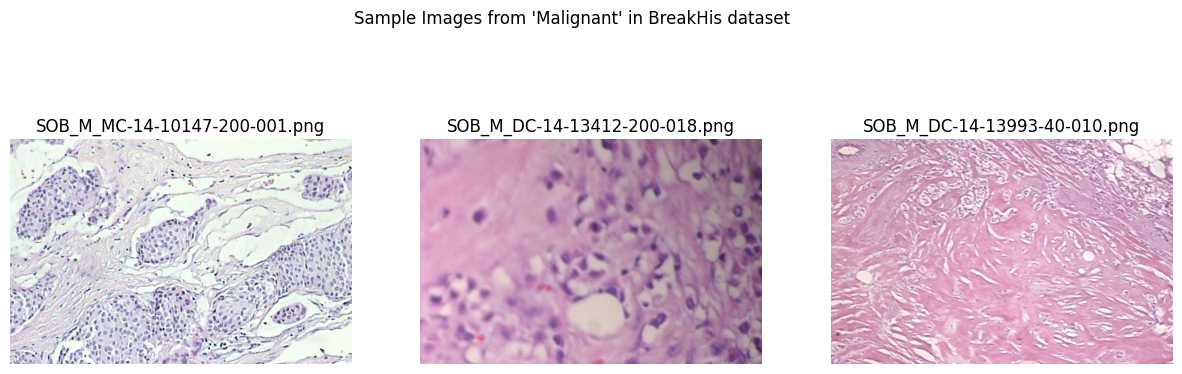

In [6]:
sample_img("Benign", num_samples=3)
sample_img("Malignant", num_samples=3)

In [7]:
def compute_image_stats(class_dir):
    widths, heights = [], []
    for file_name in os.listdir(class_dir):
        if file_name.lower().endswith((".png",".tif")):
            file_path = os.path.join(class_dir, file_name)
            with Image.open(file_path) as img:
                widths.append(img.width)
                heights.append(img.height)
    
    if widths and heights:
        return np.mean(widths), np.mean(heights)
    else:
        return None, None

In [8]:
# Dataset folder
dataset_dir = "/home/ec2-user/Research_Project/BreakHis/Dataset"

In [9]:
classes = ["Benign", "Malignant"]

In [10]:
# Compute and print average image dimensions for each class
for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    mean_width, mean_height = compute_image_stats(class_dir)
    
    if mean_width is not None:
        print(f"Average dimensions for class '{cls}': {mean_width:.1f} x {mean_height:.1f} pixels")
    else:
        print(f"No valid images found for class '{cls}' in {class_dir}.")

Average dimensions for class 'Benign': 700.0 x 460.0 pixels
Average dimensions for class 'Malignant': 700.0 x 459.9 pixels


# BACH (Testing Dataset)

In [11]:


def sample_img(class_name, num_samples=3):
    base_dir = "/home/ec2-user/Research_Project/BACH/Dataset_BACH"
    class_dir = os.path.join(base_dir, class_name)
    
    image_files = [
        os.path.join(class_dir, file)
        for file in os.listdir(class_dir)
        if file.lower().endswith((".tif"))
    ]
    
    if not image_files:
        print(f"No images found in {class_dir}.")
        return
    
    sample_images = random.sample(image_files, min(num_samples, len(image_files)))
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
    
    if len(sample_images) == 1:
        axes = [axes]
    
    for ax, img_path in zip(axes, sample_images):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(os.path.basename(img_path))
    
    plt.suptitle(f"Sample Images from '{class_name}' in BACH dataset")
    plt.show()

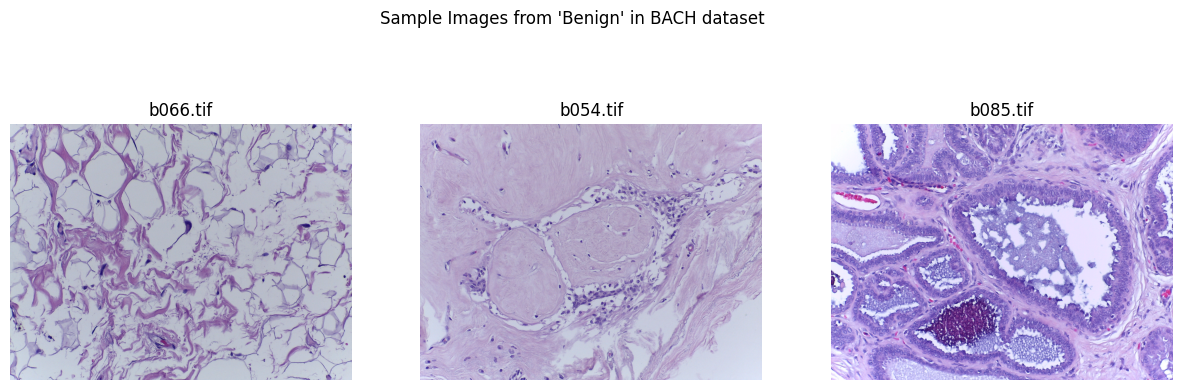

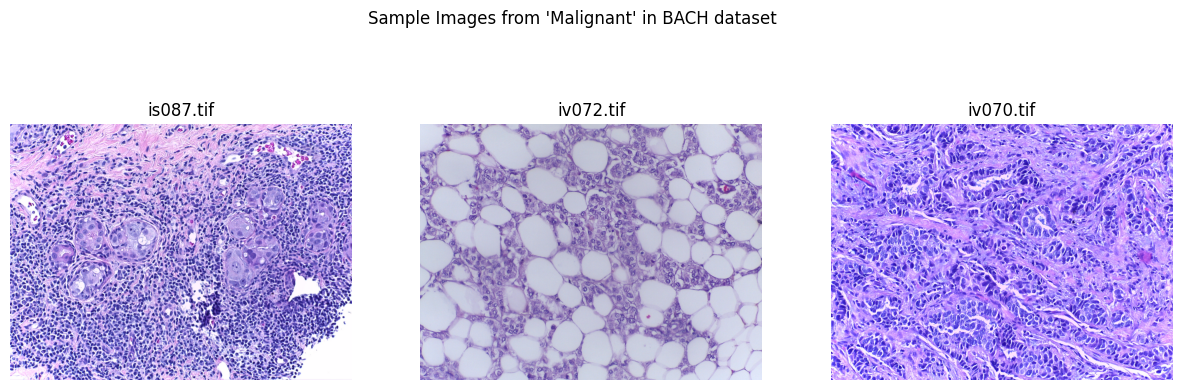

In [12]:
sample_img("Benign", num_samples=3)
sample_img("Malignant", num_samples=3)

In [13]:
# Dataset folder
bach_dataset_dir = "/home/ec2-user/Research_Project/BACH/Dataset_BACH"

In [14]:

for cls in classes:
    class_dir = os.path.join(bach_dataset_dir, cls)
    mean_width, mean_height = compute_image_stats(class_dir)
    
    if mean_width is not None:
        print(f"Average dimensions for class '{cls}': {mean_width:.1f} x {mean_height:.1f} pixels")
    else:
        print(f"No valid images found for class '{cls}' in {class_dir}.")

Average dimensions for class 'Benign': 2048.0 x 1536.0 pixels
Average dimensions for class 'Malignant': 2048.0 x 1536.0 pixels


# Common for all 3 models

In [15]:
# Common ImageNet normalization values

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

In [16]:
# Parameters and Device Setup

BATCH_SIZE = 32
NUM_CLASSES = 2          
EPOCHS_PHASE1 = 10    
EPOCHS_PHASE2 = 10      
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# Evaluation by Magnification

def get_magnification(filename):
    pattern = re.compile(r'-(40|100|200|400)-')
    match = pattern.search(filename)
    if match:
        return match.group(1) + "X"
    else:
        return "Unknown"

# Group validation images by magnification.
magnification_groups = {"40X": [], "100X": [], "200X": [], "400X": []}
magnification_true = {"40X": [], "100X": [], "200X": [], "400X": []}

# Inception-v4

In [18]:
# Data Transforms and Loading
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomResizedCrop(299, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean,
                         std=imagenet_std),
])

val_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean,
                         std=imagenet_std),
])

In [19]:
dataset_dir = '/home/ec2-user/Research_Project/BreakHis/Dataset'  

In [20]:
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=train_transform)

In [21]:
class_names = full_dataset.classes

In [22]:
# Splitinh dataset into training (80%) and validation (20%)
n_total = len(full_dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train
train_dataset, val_dataset = random_split(full_dataset, [n_train, n_val])

# For validation
val_dataset.dataset.transform = val_transform

In [23]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [24]:
print(f"Total images: {n_total}, Training: {n_train}, Validation: {n_val}")

Total images: 7930, Training: 6344, Validation: 1586


In [25]:
# Building the Inception-V4 Model

inception_model = get_model("inceptionv4", pretrained=True)
num_ftrs = inception_model.output.fc.in_features
inception_model.output.fc = nn.Linear(num_ftrs, NUM_CLASSES)
inception_model = inception_model.to(DEVICE)

In [26]:
# Loss Function and Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(inception_model.parameters(), lr=1e-3)

In [27]:
# Training and Evaluation Functions

def train_one_epoch(inception_model, dataloader, criterion, optimizer, device):
    inception_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = inception_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data).item()
        total += labels.size(0)
    return running_loss / total, correct / total

In [28]:
def evaluate(inception_model, dataloader, criterion, device):
    inception_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = inception_model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data).item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return running_loss / total, correct / total, all_labels, all_preds


In [29]:
# Phase 1: Train Classifier Only

In [30]:
# Freeze all layers except the final classifier
for name, param in inception_model.named_parameters():
    param.requires_grad = False
for param in inception_model.output.fc.parameters():
    param.requires_grad = True

print("Phase 1: Training classifier head only")
for epoch in range(EPOCHS_PHASE1):
    train_loss, train_acc = train_one_epoch(inception_model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, _, _ = evaluate(inception_model, val_loader, criterion, DEVICE)
    print(f"Epoch {epoch+1}/{EPOCHS_PHASE1} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Phase 1: Training classifier head only
Epoch 1/10 - Train Loss: 0.4524, Train Acc: 0.7974, Val Loss: 0.4043, Val Acc: 0.8203
Epoch 2/10 - Train Loss: 0.3608, Train Acc: 0.8454, Val Loss: 0.3756, Val Acc: 0.8398
Epoch 3/10 - Train Loss: 0.3410, Train Acc: 0.8564, Val Loss: 0.3505, Val Acc: 0.8462
Epoch 4/10 - Train Loss: 0.3170, Train Acc: 0.8679, Val Loss: 0.3478, Val Acc: 0.8512
Epoch 5/10 - Train Loss: 0.3146, Train Acc: 0.8707, Val Loss: 0.3733, Val Acc: 0.8625
Epoch 6/10 - Train Loss: 0.3196, Train Acc: 0.8685, Val Loss: 0.4371, Val Acc: 0.8285
Epoch 7/10 - Train Loss: 0.3054, Train Acc: 0.8696, Val Loss: 0.3345, Val Acc: 0.8531
Epoch 8/10 - Train Loss: 0.3088, Train Acc: 0.8700, Val Loss: 0.3295, Val Acc: 0.8701
Epoch 9/10 - Train Loss: 0.3023, Train Acc: 0.8717, Val Loss: 0.3544, Val Acc: 0.8638
Epoch 10/10 - Train Loss: 0.3032, Train Acc: 0.8752, Val Loss: 0.3182, Val Acc: 0.8644


In [31]:
# Phase 2: Fine-tune Entire Model

In [32]:
# Unfreeze all layers for fine-tuning
for param in inception_model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(inception_model.parameters(), lr=1e-5)  # use a lower learning rate

print("Phase 2: Fine-tuning the entire model")
for epoch in range(EPOCHS_PHASE2):
    train_loss, train_acc = train_one_epoch(inception_model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, _, _ = evaluate(inception_model, val_loader, criterion, DEVICE)
    print(f"Epoch {epoch+1}/{EPOCHS_PHASE2} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Phase 2: Fine-tuning the entire model
Epoch 1/10 - Train Loss: 0.2314, Train Acc: 0.9018, Val Loss: 0.1888, Val Acc: 0.9250
Epoch 2/10 - Train Loss: 0.1112, Train Acc: 0.9609, Val Loss: 0.1648, Val Acc: 0.9332
Epoch 3/10 - Train Loss: 0.0655, Train Acc: 0.9790, Val Loss: 0.1302, Val Acc: 0.9483
Epoch 4/10 - Train Loss: 0.0382, Train Acc: 0.9909, Val Loss: 0.1250, Val Acc: 0.9521
Epoch 5/10 - Train Loss: 0.0298, Train Acc: 0.9921, Val Loss: 0.1392, Val Acc: 0.9527
Epoch 6/10 - Train Loss: 0.0221, Train Acc: 0.9939, Val Loss: 0.1136, Val Acc: 0.9603
Epoch 7/10 - Train Loss: 0.0159, Train Acc: 0.9954, Val Loss: 0.2236, Val Acc: 0.9496
Epoch 8/10 - Train Loss: 0.0120, Train Acc: 0.9973, Val Loss: 0.2110, Val Acc: 0.9540
Epoch 9/10 - Train Loss: 0.0144, Train Acc: 0.9964, Val Loss: 0.1572, Val Acc: 0.9590
Epoch 10/10 - Train Loss: 0.0131, Train Acc: 0.9967, Val Loss: 0.1032, Val Acc: 0.9596


In [33]:
for idx in val_dataset.indices:
    path, label = full_dataset.samples[idx]
    mag = get_magnification(os.path.basename(path))
    if mag in magnification_groups:
        magnification_groups[mag].append(path)
        magnification_true[mag].append(label)

#  evaluation on a specific magnification group.
class SimpleDataset(Dataset):
    def __init__(self, file_list, labels, transform):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        image = Image.open(self.file_list[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

def get_val_loader_for_group(file_list, labels, transform):
    ds = SimpleDataset(file_list, labels, transform)
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)



In [34]:
print("\nEvaluation by Magnification:")
for mag in magnification_groups:
    print(f"\nMagnification: {mag}")
    file_list = magnification_groups[mag]
    true_labels = magnification_true[mag]
    if len(file_list) == 0:
        print("  No images found.")
        continue
    loader = get_val_loader_for_group(file_list, true_labels, val_transform)
    _, acc, all_labels, all_preds = evaluate(inception_model, loader, criterion, DEVICE)
    print(f"  Accuracy for {mag}: {acc:.4f}")
    print("  Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))


Evaluation by Magnification:

Magnification: 40X
  Accuracy for 40X: 0.9547
  Classification Report:
              precision    recall  f1-score   support

      Benign       0.93      0.93      0.93       129
   Malignant       0.97      0.97      0.97       268

    accuracy                           0.95       397
   macro avg       0.95      0.95      0.95       397
weighted avg       0.95      0.95      0.95       397


Magnification: 100X
  Accuracy for 100X: 0.9624
  Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.91      0.93       125
   Malignant       0.96      0.98      0.97       300

    accuracy                           0.96       425
   macro avg       0.96      0.95      0.95       425
weighted avg       0.96      0.96      0.96       425


Magnification: 200X
  Accuracy for 200X: 0.9746
  Classification Report:
              precision    recall  f1-score   support

      Benign       0.94      0.98      0.

In [35]:
# Evaluate the model on the validation dataset to obtain true labels and predicted labels.

_, val_acc, all_labels, all_preds = evaluate(inception_model, val_loader, criterion, DEVICE)

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 468   31]
 [  33 1054]]


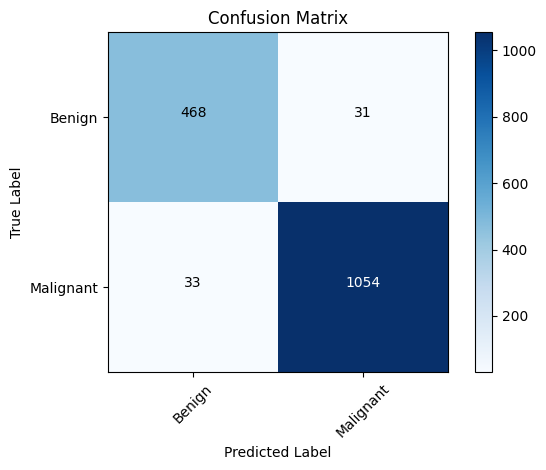

In [36]:
# confusion matrix.
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


# Testing Inception Model on External Dataset

In [37]:
external_dataset_dir = '/home/ec2-user/Research_Project/BACH/Dataset_BACH'  

external_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean ,
                         std=imagenet_std),
])


In [38]:

external_dataset = datasets.ImageFolder(external_dataset_dir, transform=external_transform)
external_loader = DataLoader(external_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"External dataset: {len(external_dataset)} images")
print("Classes:", external_dataset.classes) 

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

External dataset: 400 images
Classes: ['Benign', 'Malignant']


In [39]:
# Evaluate on External Dataset

loss_ext, acc_ext, all_labels_ext, all_preds_ext = evaluate(inception_model, external_loader, criterion, DEVICE)
print(f"External Evaluation - Loss: {loss_ext:.4f}, Accuracy: {acc_ext:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels_ext, all_preds_ext, target_names=external_dataset.classes))

External Evaluation - Loss: 2.0309, Accuracy: 0.5125

Classification Report:
              precision    recall  f1-score   support

      Benign       0.53      0.20      0.29       200
   Malignant       0.51      0.83      0.63       200

    accuracy                           0.51       400
   macro avg       0.52      0.51      0.46       400
weighted avg       0.52      0.51      0.46       400



In [40]:
# Split the external dataset
n_total = len(external_dataset)
n_finetune = int(0.2 * n_total)
n_test = n_total - n_finetune
finetune_dataset, test_dataset = random_split(external_dataset, [n_finetune, n_test])

finetune_loader = DataLoader(finetune_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
inception_test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [41]:
print(f"Fine-tuning set: {len(finetune_dataset)} images, Test set: {len(test_dataset)} images")

Fine-tuning set: 80 images, Test set: 320 images


In [42]:
# Fine-Tuning on External Data

for param in inception_model.parameters():
    param.requires_grad = True

# Use a low learning rate for fine-tuning
finetune_optimizer = optim.Adam(inception_model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [43]:
# Fine-tuning loop
finetune_epochs = 10
inception_model.train()
for epoch in range(finetune_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in finetune_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        finetune_optimizer.zero_grad()
        outputs = inception_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        finetune_optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Fine-tuning Epoch {epoch+1}/{finetune_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Fine-tuning Epoch 1/10 - Loss: 1.5187, Accuracy: 0.6875
Fine-tuning Epoch 2/10 - Loss: 0.7651, Accuracy: 0.7875
Fine-tuning Epoch 3/10 - Loss: 0.4382, Accuracy: 0.8375
Fine-tuning Epoch 4/10 - Loss: 0.1937, Accuracy: 0.9000
Fine-tuning Epoch 5/10 - Loss: 0.0779, Accuracy: 0.9750
Fine-tuning Epoch 6/10 - Loss: 0.0245, Accuracy: 0.9875
Fine-tuning Epoch 7/10 - Loss: 0.0233, Accuracy: 1.0000
Fine-tuning Epoch 8/10 - Loss: 0.0289, Accuracy: 0.9875
Fine-tuning Epoch 9/10 - Loss: 0.0144, Accuracy: 1.0000
Fine-tuning Epoch 10/10 - Loss: 0.0086, Accuracy: 1.0000


In [44]:
# Evaluation on External Test Set After Fine-Tuning

inception_model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in inception_test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = inception_model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

In [45]:
accuracy = accuracy_score(all_labels, all_preds)
print(f"External Test Set Accuracy After Fine-Tuning: {accuracy:.4f}")

print("\nExternal Test Set Evaluation After Fine-Tuning:")
print(classification_report(all_labels, all_preds, target_names=external_dataset.classes))

External Test Set Accuracy After Fine-Tuning: 0.7344

External Test Set Evaluation After Fine-Tuning:
              precision    recall  f1-score   support

      Benign       0.79      0.66      0.72       167
   Malignant       0.69      0.81      0.74       153

    accuracy                           0.73       320
   macro avg       0.74      0.74      0.73       320
weighted avg       0.74      0.73      0.73       320



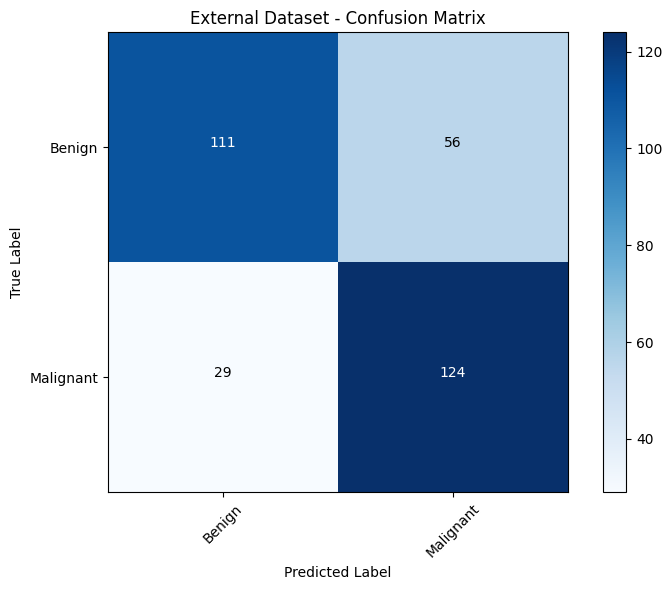

In [46]:
# Confusion Matrix for External Dataset After Fine-Tuning
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("External Dataset - Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(external_dataset.classes))
plt.xticks(tick_marks, external_dataset.classes, rotation=45)
plt.yticks(tick_marks, external_dataset.classes)
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# EfficientNet

In [47]:
dataset_dir = '/home/ec2-user/Research_Project/BreakHis/Dataset'

In [48]:
EfficientNet_train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomResizedCrop(299, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean,
                         std=imagenet_std),
])


EfficientNet_val_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean,
                         std=imagenet_std),
])

In [49]:
# Load dataset via ImageFolder
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=EfficientNet_train_transform)
class_names = full_dataset.classes 
print("Class Names:", class_names)

Class Names: ['Benign', 'Malignant']


In [50]:
# Split into training (80%) and validation (20%)
n_total = len(full_dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train
train_dataset, val_dataset = random_split(full_dataset, [n_train, n_val])

In [51]:
val_dataset.dataset.transform = EfficientNet_val_transform

In [52]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [53]:
print(f"Total images: {n_total}, Training: {n_train}, Validation: {n_val}")

Total images: 7930, Training: 6344, Validation: 1586


In [54]:
# Build the EfficientNet Model

# Using torchvision's efficientnet_b0
EfficientNet_model = models.efficientnet_b0(pretrained=True)

num_features = EfficientNet_model.classifier[1].in_features
EfficientNet_model.classifier[1] = nn.Linear(num_features, NUM_CLASSES)
EfficientNet_model = EfficientNet_model.to(DEVICE)

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
# Loss Function and Initial Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(EfficientNet_model.parameters(), lr=1e-3)

In [56]:
# Training/Evaluation Functions

def train_one_epoch(EfficientNet_model, dataloader, criterion, optimizer, device):
    EfficientNet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = EfficientNet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [57]:
def evaluate(EfficientNet_model, dataloader, criterion, device):
    EfficientNet_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = EfficientNet_model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_labels, all_preds

In [58]:
# Phase 1: Train Classifier Only

# Freeze all feature layers
for param in EfficientNet_model.features.parameters():
    param.requires_grad = False

print("Phase 1: Training classifier head only")
for epoch in range(EPOCHS_PHASE1):
    train_loss, train_acc = train_one_epoch(EfficientNet_model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, _, _ = evaluate(EfficientNet_model, val_loader, criterion, DEVICE)
    print(f"Epoch {epoch+1}/{EPOCHS_PHASE1} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Phase 1: Training classifier head only
Epoch 1/10 - Train Loss: 0.4189, Train Acc: 0.8217, Val Loss: 0.3187, Val Acc: 0.8783
Epoch 2/10 - Train Loss: 0.3364, Train Acc: 0.8607, Val Loss: 0.2805, Val Acc: 0.8878
Epoch 3/10 - Train Loss: 0.2992, Train Acc: 0.8731, Val Loss: 0.2615, Val Acc: 0.8934
Epoch 4/10 - Train Loss: 0.2957, Train Acc: 0.8786, Val Loss: 0.2421, Val Acc: 0.9073
Epoch 5/10 - Train Loss: 0.2730, Train Acc: 0.8875, Val Loss: 0.2452, Val Acc: 0.9016
Epoch 6/10 - Train Loss: 0.2653, Train Acc: 0.8870, Val Loss: 0.2347, Val Acc: 0.9111
Epoch 7/10 - Train Loss: 0.2681, Train Acc: 0.8870, Val Loss: 0.2231, Val Acc: 0.9161
Epoch 8/10 - Train Loss: 0.2560, Train Acc: 0.8949, Val Loss: 0.2256, Val Acc: 0.9048
Epoch 9/10 - Train Loss: 0.2608, Train Acc: 0.8928, Val Loss: 0.2195, Val Acc: 0.9149
Epoch 10/10 - Train Loss: 0.2484, Train Acc: 0.8983, Val Loss: 0.2127, Val Acc: 0.9168


In [59]:
# Phase 2: Fine-Tune Entire Model

# Unfreeze all layers
for param in EfficientNet_model.features.parameters():
    param.requires_grad = True

# Lower learning rate for fine-tuning
optimizer = optim.Adam(EfficientNet_model.parameters(), lr=1e-5)

print("Phase 2: Fine-tuning the entire model")
for epoch in range(EPOCHS_PHASE2):
    train_loss, train_acc = train_one_epoch(EfficientNet_model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, all_labels, all_preds = evaluate(EfficientNet_model, val_loader, criterion, DEVICE)
    print(f"Epoch {epoch+1}/{EPOCHS_PHASE2} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Phase 2: Fine-tuning the entire model
Epoch 1/10 - Train Loss: 0.2214, Train Acc: 0.9103, Val Loss: 0.1731, Val Acc: 0.9357
Epoch 2/10 - Train Loss: 0.1830, Train Acc: 0.9280, Val Loss: 0.1313, Val Acc: 0.9552
Epoch 3/10 - Train Loss: 0.1528, Train Acc: 0.9423, Val Loss: 0.1132, Val Acc: 0.9641
Epoch 4/10 - Train Loss: 0.1262, Train Acc: 0.9522, Val Loss: 0.0983, Val Acc: 0.9685
Epoch 5/10 - Train Loss: 0.1185, Train Acc: 0.9524, Val Loss: 0.0864, Val Acc: 0.9748
Epoch 6/10 - Train Loss: 0.0963, Train Acc: 0.9669, Val Loss: 0.0762, Val Acc: 0.9729
Epoch 7/10 - Train Loss: 0.0889, Train Acc: 0.9671, Val Loss: 0.0668, Val Acc: 0.9786
Epoch 8/10 - Train Loss: 0.0764, Train Acc: 0.9726, Val Loss: 0.0662, Val Acc: 0.9811
Epoch 9/10 - Train Loss: 0.0736, Train Acc: 0.9737, Val Loss: 0.0596, Val Acc: 0.9805
Epoch 10/10 - Train Loss: 0.0656, Train Acc: 0.9778, Val Loss: 0.0592, Val Acc: 0.9805


In [60]:

print("\nFinal Classification Report (Validation):")
print(classification_report(all_labels, all_preds, target_names=class_names))


Final Classification Report (Validation):
              precision    recall  f1-score   support

      Benign       0.97      0.97      0.97       508
   Malignant       0.99      0.99      0.99      1078

    accuracy                           0.98      1586
   macro avg       0.98      0.98      0.98      1586
weighted avg       0.98      0.98      0.98      1586



In [61]:
# Magnification
for idx in val_dataset.indices:
    path, label = full_dataset.samples[idx]
    mag = get_magnification(os.path.basename(path))
    if mag in magnification_groups:
        magnification_groups[mag].append(path)
        magnification_true[mag].append(label)

#  evaluation on a specific magnification group.
class SimpleDataset(Dataset):
    def __init__(self, file_list, labels, transform):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        image = Image.open(self.file_list[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

def get_val_loader_for_group(file_list, labels, transform):
    ds = SimpleDataset(file_list, labels, transform)
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [62]:
print("\nEvaluation by Magnification:")
for mag in magnification_groups:
    print(f"\nMagnification: {mag}")
    file_list = magnification_groups[mag]
    true_labels = magnification_true[mag]
    if len(file_list) == 0:
        print("  No images found.")
        continue
    loader = get_val_loader_for_group(file_list, true_labels, val_transform)
    _, acc, all_labels, all_preds = evaluate(EfficientNet_model, loader, criterion, DEVICE)
    print(f"  Accuracy for {mag}: {acc:.4f}")
    print("  Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))


Evaluation by Magnification:

Magnification: 40X
  Accuracy for 40X: 0.9938
  Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.98      0.99       254
   Malignant       0.99      1.00      1.00       552

    accuracy                           0.99       806
   macro avg       0.99      0.99      0.99       806
weighted avg       0.99      0.99      0.99       806


Magnification: 100X
  Accuracy for 100X: 0.9918
  Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99       269
   Malignant       0.99      0.99      0.99       582

    accuracy                           0.99       851
   macro avg       0.99      0.99      0.99       851
weighted avg       0.99      0.99      0.99       851


Magnification: 200X
  Accuracy for 200X: 0.9922
  Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.

Confusion Matrix:
 [[239   4]
 [ 12 489]]


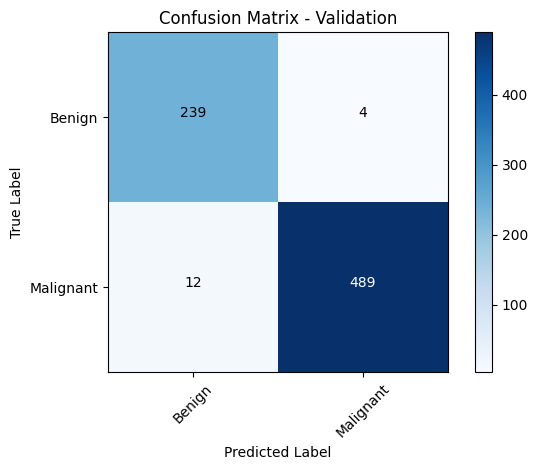

In [63]:
# Confusion Matrix

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


Validation ROC AUC: 0.9972


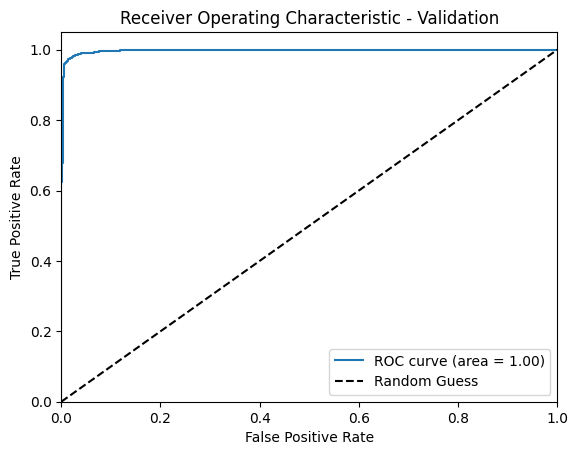

In [64]:
# ROC Curve

EfficientNet_model.eval()
all_probs = []
all_true = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = EfficientNet_model(inputs)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs[:, 1].cpu().numpy())  
        all_true.extend(labels.cpu().numpy())

fpr, tpr, _ = roc_curve(all_true, all_probs)
roc_auc = auc(fpr, tpr)
print(f"Validation ROC AUC: {roc_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic - Validation")
plt.legend(loc="lower right")
plt.show()

# Testing EfficientNet Model on External Dataset

In [65]:
external_dataset_dir = '/home/ec2-user/Research_Project/BACH/Dataset_BACH'  
finetune_epochs = 10 

In [66]:

external_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [67]:
# Load external dataset using ImageFolder
external_dataset = datasets.ImageFolder(root=external_dataset_dir, transform=external_transform)
print(f"External dataset contains {len(external_dataset)} images")
print("Classes:", external_dataset.classes)

External dataset contains 400 images
Classes: ['Benign', 'Malignant']


In [68]:
# Evaluate on External Dataset

loss_ext, acc_ext, all_labels_ext, all_preds_ext = evaluate(EfficientNet_model, external_loader, criterion, DEVICE)
print(f"External Evaluation - Loss: {loss_ext:.4f}, Accuracy: {acc_ext:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels_ext, all_preds_ext, target_names=external_dataset.classes))

External Evaluation - Loss: 1.1682, Accuracy: 0.5725

Classification Report:
              precision    recall  f1-score   support

      Benign       0.62      0.38      0.47       200
   Malignant       0.55      0.77      0.64       200

    accuracy                           0.57       400
   macro avg       0.59      0.57      0.56       400
weighted avg       0.59      0.57      0.56       400



In [69]:
# Split the external dataset
n_total = len(external_dataset)
n_finetune = int(0.2 * n_total)
n_test = n_total - n_finetune
finetune_dataset, test_dataset = random_split(external_dataset, [n_finetune, n_test])

finetune_loader = DataLoader(finetune_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
efficientnet_test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [70]:
print(f"Fine-tuning set: {len(finetune_dataset)} images, Test set: {len(test_dataset)} images")

Fine-tuning set: 80 images, Test set: 320 images


In [71]:
# Fine-Tuning on External Data

for param in EfficientNet_model.parameters():
    param.requires_grad = True

# Use a low learning rate for fine-tuning
finetune_optimizer = optim.Adam(EfficientNet_model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [72]:
# Fine-tuning loop
EfficientNet_model.train()
for epoch in range(finetune_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in finetune_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        finetune_optimizer.zero_grad()
        outputs = EfficientNet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        finetune_optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Fine-tuning Epoch {epoch+1}/{finetune_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Fine-tuning Epoch 1/10 - Loss: 1.3118, Accuracy: 0.6250
Fine-tuning Epoch 2/10 - Loss: 1.2514, Accuracy: 0.6375
Fine-tuning Epoch 3/10 - Loss: 1.1400, Accuracy: 0.6125
Fine-tuning Epoch 4/10 - Loss: 1.0395, Accuracy: 0.6375
Fine-tuning Epoch 5/10 - Loss: 0.8989, Accuracy: 0.6750
Fine-tuning Epoch 6/10 - Loss: 0.8962, Accuracy: 0.7000
Fine-tuning Epoch 7/10 - Loss: 0.6885, Accuracy: 0.7125
Fine-tuning Epoch 8/10 - Loss: 0.8756, Accuracy: 0.7375
Fine-tuning Epoch 9/10 - Loss: 0.8962, Accuracy: 0.7250
Fine-tuning Epoch 10/10 - Loss: 0.5522, Accuracy: 0.7750


In [73]:
# Evaluation on External Test Set

EfficientNet_model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in efficientnet_test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = EfficientNet_model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

In [74]:
accuracy = accuracy_score(all_labels, all_preds)
print(f"External Test Set Accuracy: {accuracy:.4f}")

print("\nExternal Test Set Evaluation After Fine-Tuning:")
print(classification_report(all_labels, all_preds, target_names=external_dataset.classes))


External Test Set Accuracy: 0.7094

External Test Set Evaluation After Fine-Tuning:
              precision    recall  f1-score   support

      Benign       0.87      0.51      0.64       164
   Malignant       0.64      0.92      0.76       156

    accuracy                           0.71       320
   macro avg       0.76      0.71      0.70       320
weighted avg       0.76      0.71      0.70       320



External Test Set ROC AUC: 0.8231


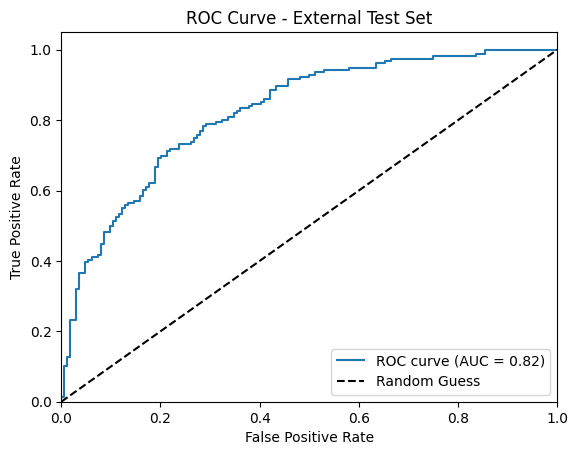

In [75]:
# Compute and plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
print(f"External Test Set ROC AUC: {roc_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - External Test Set")
plt.legend(loc="lower right")
plt.show()

# ViT

In [76]:
vit_initial_epochs = 10 
vit_finetune_epochs = 10   
IMG_SIZE = 224

In [77]:
# Data Transforms 

vit_train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean,
                         std=imagenet_std),
])

vit_val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean,
                         std=imagenet_std),
])

In [78]:
vit_dataset_dir = "/home/ec2-user/Research_Project/BreakHis/Dataset"
vit_full_dataset = datasets.ImageFolder(root=vit_dataset_dir, transform=vit_train_transform)
vit_class_names = vit_full_dataset.classes
print("ViT Classes:", vit_class_names)

ViT Classes: ['Benign', 'Malignant']


In [79]:
n_total = len(vit_full_dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train
vit_train_dataset, vit_val_dataset = random_split(vit_full_dataset, [n_train, n_val])

vit_val_dataset.dataset.transform = vit_val_transform

In [80]:
vit_train_loader = DataLoader(vit_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
vit_val_loader = DataLoader(vit_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [81]:
# Building the ViT Model using timm

vit_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=NUM_CLASSES)
vit_model = vit_model.to(DEVICE)

In [82]:
# Loss Function and Optimizer

vit_criterion = nn.CrossEntropyLoss()
vit_optimizer = optim.Adam(vit_model.parameters(), lr=1e-3)

In [83]:
# Training 

def vit_train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

In [84]:
# Evalaation

def vit_evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return running_loss / total, correct / total, all_labels, all_preds


In [85]:
# Phase 1: Train Classifier Head Only 

In [86]:
# Freeze all parameters

for param in vit_model.parameters():
    param.requires_grad = False

In [87]:
# Unfreeze the classifier head parameters.

if hasattr(vit_model, 'head'):
    for param in vit_model.head.parameters():
        param.requires_grad = True
elif hasattr(vit_model, 'classifier'):
    for param in vit_model.classifier.parameters():
        param.requires_grad = True

In [88]:
print("ViT Phase 1: Training classifier head only...")
for epoch in range(vit_initial_epochs):
    vit_train_loss, vit_train_acc = vit_train_one_epoch(vit_model, vit_train_loader, vit_criterion, vit_optimizer, DEVICE)
    vit_val_loss, vit_val_acc, vit_all_labels, vit_all_preds = vit_evaluate(vit_model, vit_val_loader, vit_criterion, DEVICE)
    print(f"ViT Phase 1 Epoch {epoch+1}/{vit_initial_epochs} - Train Loss: {vit_train_loss:.4f}, Train Acc: {vit_train_acc:.4f}, Val Loss: {vit_val_loss:.4f}, Val Acc: {vit_val_acc:.4f}")

print("\nViT Validation Accuracy after Phase 1:", vit_val_acc)

ViT Phase 1: Training classifier head only...
ViT Phase 1 Epoch 1/10 - Train Loss: 0.3423, Train Acc: 0.8512, Val Loss: 0.2663, Val Acc: 0.8985
ViT Phase 1 Epoch 2/10 - Train Loss: 0.2408, Train Acc: 0.9015, Val Loss: 0.2304, Val Acc: 0.9054
ViT Phase 1 Epoch 3/10 - Train Loss: 0.2122, Train Acc: 0.9176, Val Loss: 0.2692, Val Acc: 0.8846
ViT Phase 1 Epoch 4/10 - Train Loss: 0.1965, Train Acc: 0.9248, Val Loss: 0.2584, Val Acc: 0.8991
ViT Phase 1 Epoch 5/10 - Train Loss: 0.1860, Train Acc: 0.9259, Val Loss: 0.2104, Val Acc: 0.9174
ViT Phase 1 Epoch 6/10 - Train Loss: 0.1722, Train Acc: 0.9369, Val Loss: 0.1936, Val Acc: 0.9243
ViT Phase 1 Epoch 7/10 - Train Loss: 0.1655, Train Acc: 0.9379, Val Loss: 0.1991, Val Acc: 0.9237
ViT Phase 1 Epoch 8/10 - Train Loss: 0.1629, Train Acc: 0.9395, Val Loss: 0.2260, Val Acc: 0.9124
ViT Phase 1 Epoch 9/10 - Train Loss: 0.1572, Train Acc: 0.9404, Val Loss: 0.1898, Val Acc: 0.9300
ViT Phase 1 Epoch 10/10 - Train Loss: 0.1541, Train Acc: 0.9403, Val Los

In [89]:
# Phase 2: Fine-Tuning Entire Model (Unfreeze All Layers)

In [90]:

for param in vit_model.parameters():
    param.requires_grad = True

# Use a lower learning rate for fine-tuning
vit_optimizer = optim.Adam(vit_model.parameters(), lr=1e-5)

In [91]:
print("\nViT Phase 2: Fine-Tuning entire model...")
for epoch in range(vit_finetune_epochs):
    vit_train_loss, vit_train_acc = vit_train_one_epoch(vit_model, vit_train_loader, vit_criterion, vit_optimizer, DEVICE)
    vit_val_loss, vit_val_acc, vit_all_labels, vit_all_preds = vit_evaluate(vit_model, vit_val_loader, vit_criterion, DEVICE)
    print(f"ViT Phase 2 Epoch {epoch+1}/{vit_finetune_epochs} - Train Loss: {vit_train_loss:.4f}, Train Acc: {vit_train_acc:.4f}, Val Loss: {vit_val_loss:.4f}, Val Acc: {vit_val_acc:.4f}")

print("\nViT Final Validation Accuracy after Fine-Tuning:", vit_val_acc)


ViT Phase 2: Fine-Tuning entire model...
ViT Phase 2 Epoch 1/10 - Train Loss: 0.1752, Train Acc: 0.9365, Val Loss: 0.1080, Val Acc: 0.9615
ViT Phase 2 Epoch 2/10 - Train Loss: 0.0421, Train Acc: 0.9844, Val Loss: 0.1096, Val Acc: 0.9609
ViT Phase 2 Epoch 3/10 - Train Loss: 0.0232, Train Acc: 0.9918, Val Loss: 0.1374, Val Acc: 0.9515
ViT Phase 2 Epoch 4/10 - Train Loss: 0.0250, Train Acc: 0.9920, Val Loss: 0.0863, Val Acc: 0.9760
ViT Phase 2 Epoch 5/10 - Train Loss: 0.0195, Train Acc: 0.9927, Val Loss: 0.0609, Val Acc: 0.9823
ViT Phase 2 Epoch 6/10 - Train Loss: 0.0076, Train Acc: 0.9973, Val Loss: 0.0940, Val Acc: 0.9754
ViT Phase 2 Epoch 7/10 - Train Loss: 0.0096, Train Acc: 0.9953, Val Loss: 0.0687, Val Acc: 0.9836
ViT Phase 2 Epoch 8/10 - Train Loss: 0.0050, Train Acc: 0.9976, Val Loss: 0.0702, Val Acc: 0.9842
ViT Phase 2 Epoch 9/10 - Train Loss: 0.0185, Train Acc: 0.9951, Val Loss: 0.0830, Val Acc: 0.9748
ViT Phase 2 Epoch 10/10 - Train Loss: 0.0318, Train Acc: 0.9891, Val Loss: 0

In [92]:
# Final Evaluation on Validation Set
# -------------------------------
print("\nViT Validation Classification Report after Fine Tuning:")
print(classification_report(vit_all_labels, vit_all_preds, target_names=vit_class_names))

cm_vit = confusion_matrix(vit_all_labels, vit_all_preds)
print("ViT Confusion Matrix:\n", cm_vit)


ViT Validation Classification Report after Fine Tuning:
              precision    recall  f1-score   support

      Benign       0.95      0.97      0.96       465
   Malignant       0.99      0.98      0.98      1121

    accuracy                           0.98      1586
   macro avg       0.97      0.98      0.97      1586
weighted avg       0.98      0.98      0.98      1586

ViT Confusion Matrix:
 [[ 453   12]
 [  24 1097]]


In [93]:
print("\nEvaluation by Magnification:")
for mag in magnification_groups:
    print(f"\nMagnification: {mag}")
    file_list = magnification_groups[mag]
    true_labels = magnification_true[mag]
    if len(file_list) == 0:
        print("  No images found.")
        continue
    loader = get_val_loader_for_group(file_list, true_labels, vit_val_transform)
    _, acc, all_labels, all_preds = evaluate(vit_model, loader, criterion, DEVICE)
    print(f"  Accuracy for {mag}: {acc:.4f}")
    print("  Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=vit_class_names))


Evaluation by Magnification:

Magnification: 40X
  Accuracy for 40X: 0.9963
  Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      1.00      0.99       254
   Malignant       1.00      0.99      1.00       552

    accuracy                           1.00       806
   macro avg       0.99      1.00      1.00       806
weighted avg       1.00      1.00      1.00       806


Magnification: 100X
  Accuracy for 100X: 0.9953
  Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      1.00      0.99       269
   Malignant       1.00      0.99      1.00       582

    accuracy                           1.00       851
   macro avg       0.99      1.00      0.99       851
weighted avg       1.00      1.00      1.00       851


Magnification: 200X
  Accuracy for 200X: 0.9961
  Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      1.00      0.

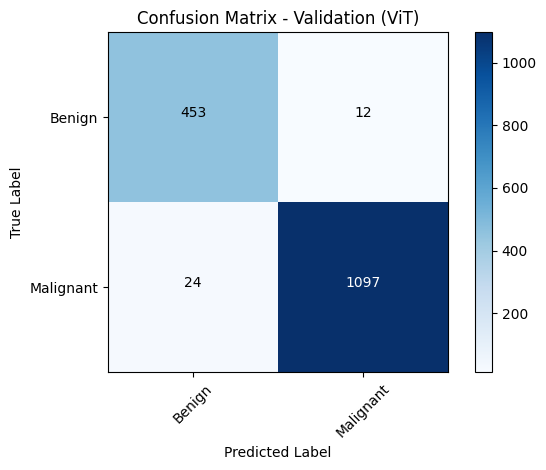

In [94]:
plt.figure()
plt.imshow(cm_vit, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation (ViT)")
plt.colorbar()
tick_marks = np.arange(len(vit_class_names))
plt.xticks(tick_marks, vit_class_names, rotation=45)
plt.yticks(tick_marks, vit_class_names)
thresh = cm_vit.max() / 2.0
for i, j in itertools.product(range(cm_vit.shape[0]), range(cm_vit.shape[1])):
    plt.text(j, i, format(cm_vit[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_vit[i, j] > thresh else "black")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# Testing ViT Model on External Dataset

In [95]:

vit_external_dataset_dir = '/home/ec2-user/Research_Project/BACH/Dataset_BACH'

In [96]:
vit_external_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])


In [97]:
 
vit_ext_full_dataset = datasets.ImageFolder(root=vit_external_dataset_dir, transform=vit_external_transform)
external_loader = DataLoader(vit_ext_full_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
print(f"External dataset contains {len(vit_ext_full_dataset)} images")
print("Classes:", vit_ext_full_dataset.classes)
print("Class to index mapping:", vit_ext_full_dataset.class_to_idx)

External dataset contains 400 images
Classes: ['Benign', 'Malignant']
Class to index mapping: {'Benign': 0, 'Malignant': 1}


In [98]:
# Evaluate on External Dataset

loss_ext, acc_ext, all_labels_ext, all_preds_ext = evaluate(vit_model, external_loader, criterion, DEVICE)
print(f"External Evaluation - Loss: {loss_ext:.4f}, Accuracy: {acc_ext:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels_ext, all_preds_ext, target_names=external_dataset.classes))

External Evaluation - Loss: 2.2279, Accuracy: 0.6375

Classification Report:
              precision    recall  f1-score   support

      Benign       0.78      0.39      0.52       200
   Malignant       0.59      0.89      0.71       200

    accuracy                           0.64       400
   macro avg       0.68      0.64      0.61       400
weighted avg       0.68      0.64      0.61       400



In [99]:
# dataset spliting
n_ext_total = len(vit_ext_full_dataset)
n_ext_finetune = int(0.2 * n_ext_total)
n_ext_test = n_ext_total - n_ext_finetune
vit_ext_finetune_dataset, vit_ext_test_dataset = random_split(vit_ext_full_dataset, [n_ext_finetune, n_ext_test])


In [100]:
vit_ext_finetune_loader = DataLoader(vit_ext_finetune_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
vit_ext_test_loader = DataLoader(vit_ext_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [101]:
print(f"External Fine-Tuning set: {n_ext_finetune} images, Test set: {n_ext_test} images")

External Fine-Tuning set: 80 images, Test set: 320 images


In [102]:
# Fine-Tuning on External Dataset (ViT)

for param in vit_model.parameters():
    param.requires_grad = True

vit_ext_optimizer = optim.Adam(vit_model.parameters(), lr=1e-5)
vit_ext_criterion = nn.CrossEntropyLoss()

In [103]:
vit_model.train()
for epoch in range(vit_finetune_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in vit_ext_finetune_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        vit_ext_optimizer.zero_grad()
        outputs = vit_model(inputs)
        loss = vit_ext_criterion(outputs, labels)
        loss.backward()
        vit_ext_optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"External Fine-Tuning Epoch {epoch+1}/{vit_finetune_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

External Fine-Tuning Epoch 1/10 - Loss: 1.8885, Accuracy: 0.6750
External Fine-Tuning Epoch 2/10 - Loss: 0.4405, Accuracy: 0.8375
External Fine-Tuning Epoch 3/10 - Loss: 0.2273, Accuracy: 0.9000
External Fine-Tuning Epoch 4/10 - Loss: 0.1128, Accuracy: 0.9500
External Fine-Tuning Epoch 5/10 - Loss: 0.0335, Accuracy: 0.9875
External Fine-Tuning Epoch 6/10 - Loss: 0.0038, Accuracy: 1.0000
External Fine-Tuning Epoch 7/10 - Loss: 0.0062, Accuracy: 1.0000
External Fine-Tuning Epoch 8/10 - Loss: 0.0108, Accuracy: 1.0000
External Fine-Tuning Epoch 9/10 - Loss: 0.0094, Accuracy: 1.0000
External Fine-Tuning Epoch 10/10 - Loss: 0.0054, Accuracy: 1.0000


In [104]:
# Evaluation on External Test Set (after Fine-Tuning)

vit_model.eval()
vit_ext_all_labels = []
vit_ext_all_preds = []
vit_ext_all_probs = [] 

with torch.no_grad():
    for inputs, labels in vit_ext_test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = vit_model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)
        
        vit_ext_all_labels.extend(labels.cpu().numpy())
        vit_ext_all_preds.extend(preds.cpu().numpy())
        vit_ext_all_probs.extend(probs[:, 1].cpu().numpy())

vit_ext_accuracy = accuracy_score(vit_ext_all_labels, vit_ext_all_preds)
print(f"\nExternal Test Set Accuracy after Fine-Tuning: {vit_ext_accuracy:.4f}")


External Test Set Accuracy after Fine-Tuning: 0.8000


In [105]:
print("\nExternal Testing Classification Report after Fine-Tuning:")
print(classification_report(vit_ext_all_labels, vit_ext_all_preds, target_names=vit_ext_full_dataset.classes))

vit_ext_cm = confusion_matrix(vit_ext_all_labels, vit_ext_all_preds)
print("External Confusion Matrix:\n", vit_ext_cm)


External Testing Classification Report after Fine-Tuning:
              precision    recall  f1-score   support

      Benign       0.84      0.73      0.78       154
   Malignant       0.77      0.87      0.82       166

    accuracy                           0.80       320
   macro avg       0.81      0.80      0.80       320
weighted avg       0.80      0.80      0.80       320

External Confusion Matrix:
 [[112  42]
 [ 22 144]]


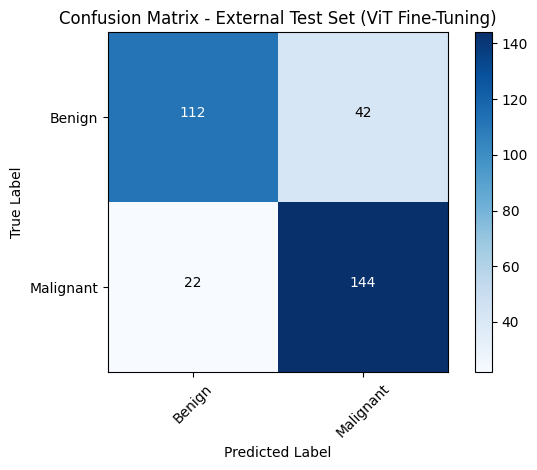

In [106]:
plt.figure()
plt.imshow(vit_ext_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - External Test Set (ViT Fine-Tuning)")
plt.colorbar()
tick_marks = np.arange(len(vit_ext_full_dataset.classes))
plt.xticks(tick_marks, vit_ext_full_dataset.classes, rotation=45)
plt.yticks(tick_marks, vit_ext_full_dataset.classes)
thresh = vit_ext_cm.max() / 2.0
for i, j in itertools.product(range(vit_ext_cm.shape[0]), range(vit_ext_cm.shape[1])):
    plt.text(j, i, format(vit_ext_cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if vit_ext_cm[i, j] > thresh else "black")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

In [107]:
vit_ext_fpr, vit_ext_tpr, _ = roc_curve(vit_ext_all_labels, vit_ext_all_probs)
vit_ext_roc_auc = auc(vit_ext_fpr, vit_ext_tpr)
print(f"External Test Set ROC AUC after Fine-Tuning: {vit_ext_roc_auc:.4f}")

External Test Set ROC AUC after Fine-Tuning: 0.9022


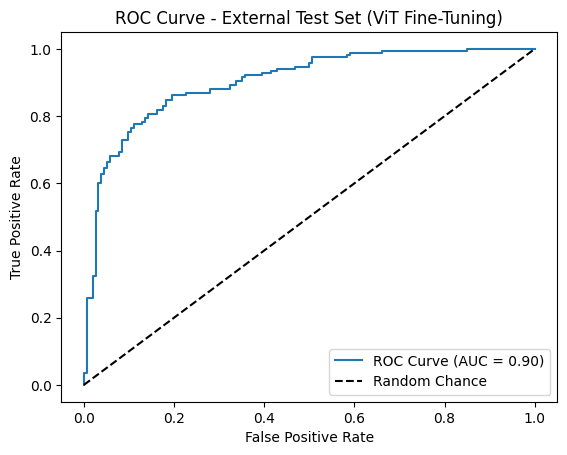

In [108]:
plt.figure()
plt.plot(vit_ext_fpr, vit_ext_tpr, label=f"ROC Curve (AUC = {vit_ext_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - External Test Set (ViT Fine-Tuning)")
plt.legend(loc="lower right")
plt.show()

# Ensemble Approch using Logistic regression classifier

In [109]:
def sorted_imagefolder(root, transform):
    dataset = ImageFolder(root=root, transform=transform)
    dataset.samples = sorted(dataset.samples, key=lambda x: os.path.basename(x[0]))
    return dataset

In [110]:

# For Inception and EfficientNet
inception_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
efficientnet_transform = inception_transform  # same as Inception

# For ViT
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])



In [111]:
# Sorted Datasets
dataset_dir = '/home/ec2-user/Research_Project/BACH/Dataset_BACH'
base_dataset = sorted_imagefolder(dataset_dir, inception_transform)

In [112]:
def load_and_transform(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image)



In [113]:
def get_base_model_predictions_from_image(image_inc, image_eff, image_vit, models, device):
    outputs = []
    with torch.no_grad():
        # Inception
        out_inc = models[0](image_inc.to(device))
        probs_inc = torch.softmax(out_inc, dim=1)
        outputs.append(probs_inc.cpu().numpy())
        
        # EfficientNet
        out_eff = models[1](image_eff.to(device))
        probs_eff = torch.softmax(out_eff, dim=1)
        outputs.append(probs_eff.cpu().numpy())
        
        # ViT
        out_vit = models[2](image_vit.to(device))
        probs_vit = torch.softmax(out_vit, dim=1)
        outputs.append(probs_vit.cpu().numpy())
        
    stacked_features = np.concatenate(outputs, axis=1)
    return stacked_features

In [114]:

models_list = [inception_model, EfficientNet_model, vit_model]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_labels = []
meta_features_list = []


for image_path, label in base_dataset.samples:
    image_inc = load_and_transform(image_path, inception_transform).unsqueeze(0)  
    image_eff = load_and_transform(image_path, efficientnet_transform).unsqueeze(0)  
    image_vit = load_and_transform(image_path, vit_transform).unsqueeze(0)  
    
    features = get_base_model_predictions_from_image(image_inc, image_eff, image_vit, models_list, DEVICE)
    meta_features_list.append(features)
    all_labels.append(label)

meta_features = np.vstack(meta_features_list)
all_labels = np.array(all_labels)

In [115]:
# Meta-Classifier (Stacking)

meta_train_feats, meta_val_feats, meta_train_labels, meta_val_labels = train_test_split(
    meta_features, all_labels, test_size=0.3, random_state=42
)

# Logistic Regression as meta-classifier
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(meta_train_feats, meta_train_labels)



LogisticRegression(max_iter=1000)

In [116]:

meta_val_preds = meta_model.predict(meta_val_feats)
print("Meta-Classifier (Stacking) Classification Report (Validation Split):")
print(classification_report(meta_val_labels, meta_val_preds, target_names=['Benign', 'Malignant']))



Meta-Classifier (Stacking) Classification Report (Validation Split):
              precision    recall  f1-score   support

      Benign       0.92      0.89      0.91        65
   Malignant       0.88      0.91      0.89        55

    accuracy                           0.90       120
   macro avg       0.90      0.90      0.90       120
weighted avg       0.90      0.90      0.90       120



In [117]:

stacked_preds = meta_model.predict(meta_features)
print("Classification Report (Stacking Ensemble):")
print(classification_report(all_labels, stacked_preds, target_names=['Benign', 'Malignant']))



Classification Report (Stacking Ensemble):
              precision    recall  f1-score   support

      Benign       0.89      0.85      0.87       200
   Malignant       0.86      0.89      0.87       200

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



In [118]:
# overall accuracy.
ensemble_accuracy = accuracy_score(all_labels, stacked_preds)
print("Ensemble Test Accuracy:", ensemble_accuracy)



Ensemble Test Accuracy: 0.87


Confusion Matrix:
[[170  30]
 [ 22 178]]


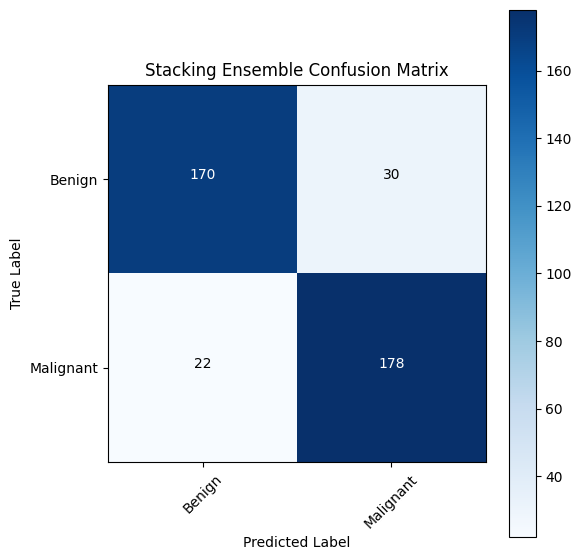

In [119]:
cm = confusion_matrix(all_labels, stacked_preds)
print("Confusion Matrix:")
print(cm)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Stacking Ensemble Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Benign', 'Malignant'], rotation=45)
plt.yticks(tick_marks, ['Benign', 'Malignant'])
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()



ROC AUC (Stacking Ensemble): 0.9436


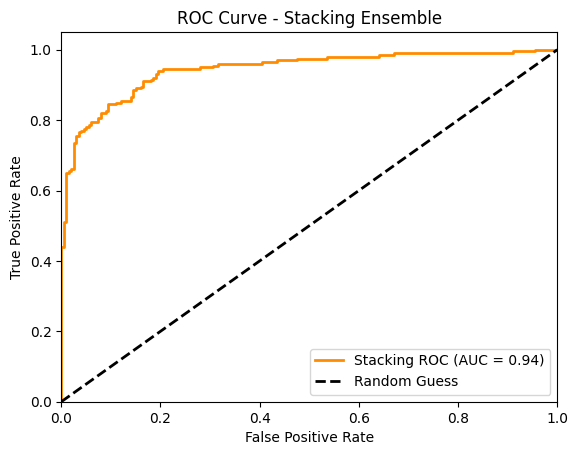

In [120]:
stacked_probs = meta_model.predict_proba(meta_features)  
fpr, tpr, _ = roc_curve(all_labels, stacked_probs[:, 1])
roc_auc = auc(fpr, tpr)
print("ROC AUC (Stacking Ensemble):", roc_auc)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label="Stacking ROC (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Stacking Ensemble")
plt.legend(loc="lower right")
plt.show()

# Ensemble Approch using Random Forest classifier

In [121]:
meta_features = np.vstack(meta_features_list)
all_labels = np.array(all_labels)


meta_train_feats, meta_test_feats, meta_train_labels, meta_test_labels = train_test_split(
    meta_features, all_labels, test_size=0.3, random_state=42
)

# Random Forest Regressor.
rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42)


In [122]:

rf_regressor.fit(meta_train_feats, meta_train_labels)
meta_test_pred_cont = rf_regressor.predict(meta_test_feats)
meta_test_pred = (meta_test_pred_cont > 0.5).astype(int)

validation_accuracy = accuracy_score(meta_test_labels, meta_test_pred)

In [123]:
stacked_preds_cont = rf_regressor.predict(meta_features)
stacked_preds = (stacked_preds_cont > 0.5).astype(int)

overall_accuracy = accuracy_score(all_labels, stacked_preds)

print("Classification Report (Stacking Ensemble with Tuned RF Regressor on Full Test Set):")
print("Overall Accuracy: {:.2f}%".format(overall_accuracy * 100))
print(classification_report(all_labels, stacked_preds, target_names=['Benign', 'Malignant']))

Classification Report (Stacking Ensemble with Tuned RF Regressor on Full Test Set):
Overall Accuracy: 96.00%
              precision    recall  f1-score   support

      Benign       0.96      0.95      0.96       200
   Malignant       0.96      0.96      0.96       200

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



# Grad-CAM implementation

In [124]:
#  defininhg functions

def load_image_and_transform(image_path, transform):
    orig_img = Image.open(image_path).convert("RGB")
    transformed = transform(orig_img)
    return orig_img, transformed.unsqueeze(0)


def overlay_cam_on_image(img, mask, alpha=0.5):
    mask = np.squeeze(mask)
    if mask.ndim != 2:
        mask = mask[..., 0]
    
    mask_uint8 = np.uint8(255 * mask)
    heatmap = cv2.applyColorMap(mask_uint8, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlayed = cv2.addWeighted(np.uint8(img), 1 - alpha, heatmap, alpha, 0)
    return overlayed


In [125]:

def generate_and_show_gradcam(image_path, model, target_layer, transform, device):
    orig_img, img_tensor = load_image_and_transform(image_path, transform)
    img_tensor = img_tensor.to(device)
    model.eval()
    cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)
    output = model(img_tensor)
    pred_class = int(output.argmax(dim=1).item())
    cam = cam_extractor(pred_class, output)[0].cpu().numpy()
    cam = cv2.resize(cam, (orig_img.width, orig_img.height))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-10)
    
    #overlay.
    img_np = np.array(orig_img)
    cam_overlay = overlay_cam_on_image(img_np, cam, alpha=0.5)
    

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(cam_overlay)
    plt.title(f"Grad-CAM Overlay\nPredicted: {pred_class}")
    plt.axis("off")
    plt.suptitle(f"Model: {model.__class__.__name__} | Target Layer: {target_layer}")
    plt.show()

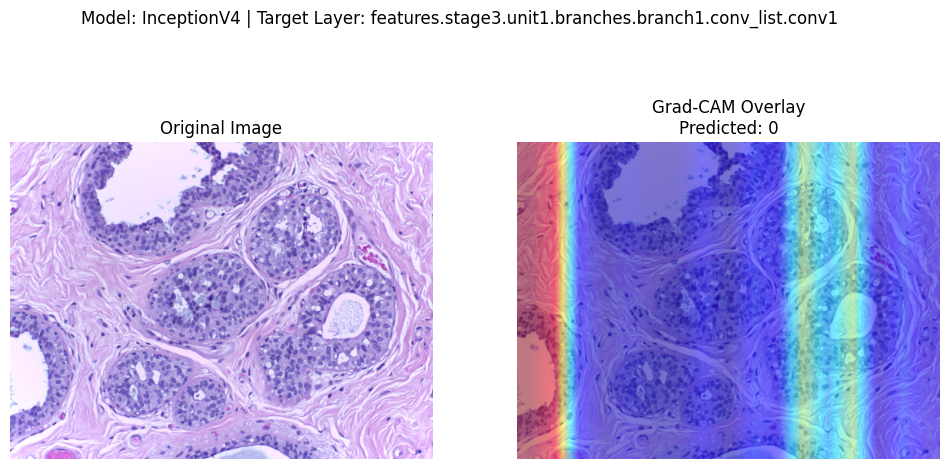

In [127]:
#Sample Image 
sample_image_path = "/home/ec2-user/Research_Project/BACH/Dataset_BACH/Benign/b003.tif"  


# for Inception-v4 model
target_layer_inception = "features.stage3.unit1.branches.branch1.conv_list.conv1"  # Example candidate; adjust as needed.
generate_and_show_gradcam(sample_image_path, inception_model, target_layer_inception, inception_transform, DEVICE)


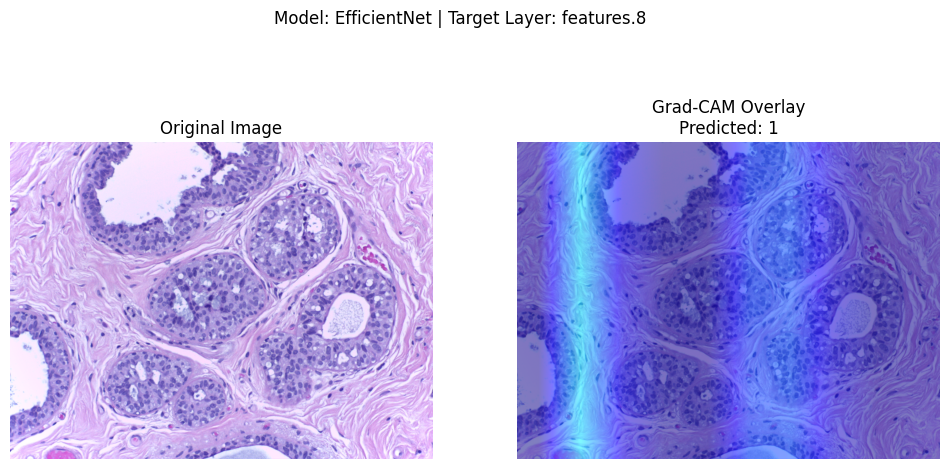

In [129]:
# For EfficientNet-B0
target_layer_efficientnet = "features.8"
generate_and_show_gradcam(sample_image_path, EfficientNet_model, target_layer_efficientnet, efficientnet_transform, DEVICE)



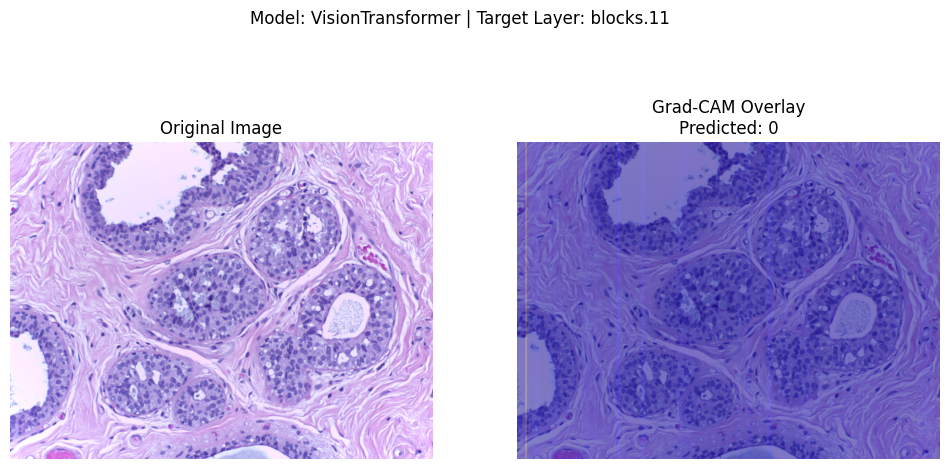

In [130]:
# For ViT
target_layer_vit = "blocks.11"  
generate_and_show_gradcam(sample_image_path, vit_model, target_layer_vit, vit_transform, DEVICE)

# Applying Imaging Artifacts

In [142]:
# Gaussian Noise 
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"


In [143]:
# Define perturbation transforms:
gaussian_noise = AddGaussianNoise(mean=0.0, std=0.1)
gaussian_blur  = transforms.GaussianBlur(kernel_size=5, sigma=1.0)
color_jitter   = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)



def sorted_imagefolder(root, transform):
    dataset = ImageFolder(root=root, transform=transform)
    dataset.samples = sorted(dataset.samples, key=lambda x: os.path.basename(x[0]))
    return dataset

def get_perturbed_dataloader(dataset_dir, baseline_transform, perturb_transform, batch_size=32, num_workers=4):
    combined_transform = transforms.Compose([
        baseline_transform,
        perturb_transform
    ])
    ds = sorted_imagefolder(dataset_dir, combined_transform)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return dl

def evaluate_model(model, dataloader, device):
    """Evaluate the model accuracy; gradient tracking is enabled to satisfy hooks."""
    model.eval()
    correct = 0
    total = 0
    with torch.enable_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total if total > 0 else 0.0

In [144]:
dataset_dir = '/home/ec2-user/Research_Project/BACH/Dataset_BACH'
BATCH_SIZE = 32

inception_baseline_loader = DataLoader(
    sorted_imagefolder(dataset_dir, inception_transform), 
    batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)
efficientnet_baseline_loader = DataLoader(
    sorted_imagefolder(dataset_dir, efficientnet_transform), 
    batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)
vit_baseline_loader = DataLoader(
    sorted_imagefolder(dataset_dir, vit_transform), 
    batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)

acc_inception_baseline = evaluate_model(inception_model, inception_baseline_loader, DEVICE)
acc_efficientnet_baseline = evaluate_model(EfficientNet_model, efficientnet_baseline_loader, DEVICE)
acc_vit_baseline = evaluate_model(vit_model, vit_baseline_loader, DEVICE)

In [145]:
results = {
    "Inception Baseline": acc_inception_baseline,
    "EfficientNet Baseline": acc_efficientnet_baseline,
    "ViT Baseline": acc_vit_baseline
}


perturbations = [
    ("Gaussian Noise", gaussian_noise),
    ("Gaussian Blur", gaussian_blur),
    ("Color Jitter", color_jitter)
]


for perturb_name, perturb_tf in perturbations:
    # Inception:
    loader = get_perturbed_dataloader(dataset_dir, inception_transform, perturb_tf, batch_size=BATCH_SIZE, num_workers=4)
    acc = evaluate_model(inception_model, loader, DEVICE)
    results[f"Inception {perturb_name}"] = acc
    # EfficientNet:
    loader = get_perturbed_dataloader(dataset_dir, efficientnet_transform, perturb_tf, batch_size=BATCH_SIZE, num_workers=4)
    acc = evaluate_model(EfficientNet_model, loader, DEVICE)
    results[f"EfficientNet {perturb_name}"] = acc
    # ViT:
    loader = get_perturbed_dataloader(dataset_dir, vit_transform, perturb_tf, batch_size=BATCH_SIZE, num_workers=4)
    acc = evaluate_model(vit_model, loader, DEVICE)
    results[f"ViT {perturb_name}"] = acc

print("Model Accuracy under Perturbations:")
for k in sorted(results.keys()):
    print(f"{k}: {results[k]*100:.2f}%")

Model Accuracy under Perturbations:
EfficientNet Baseline: 52.25%
EfficientNet Color Jitter: 52.00%
EfficientNet Gaussian Blur: 50.25%
EfficientNet Gaussian Noise: 54.25%
Inception Baseline: 62.50%
Inception Color Jitter: 54.25%
Inception Gaussian Blur: 51.50%
Inception Gaussian Noise: 66.25%
ViT Baseline: 84.00%
ViT Color Jitter: 73.00%
ViT Gaussian Blur: 82.50%
ViT Gaussian Noise: 86.25%


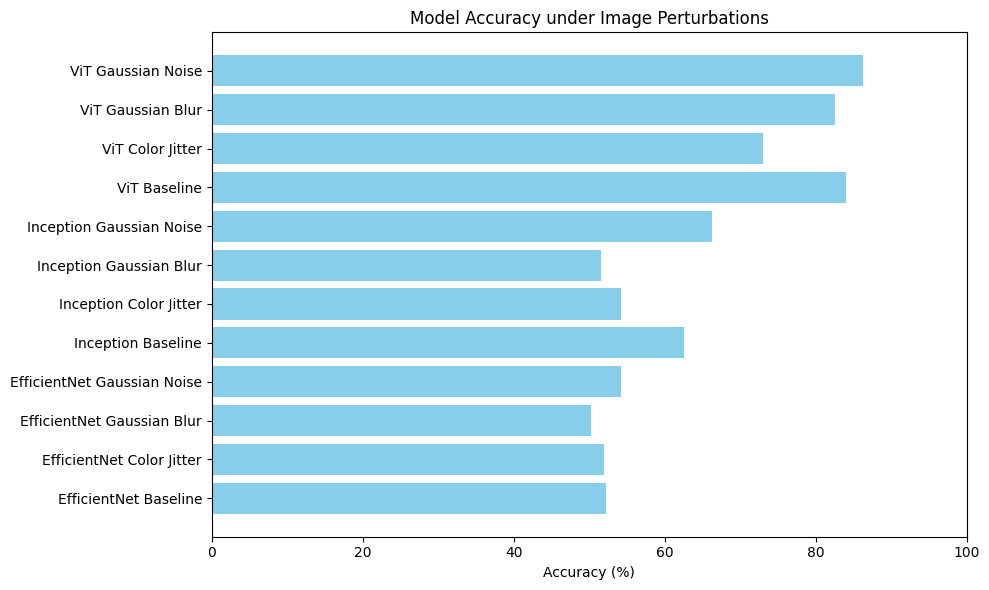

In [146]:
# barchart

sorted_keys = sorted(results.keys())
accuracies = [results[k]*100 for k in sorted_keys]
plt.figure(figsize=(10, 6))
plt.barh(sorted_keys, accuracies, color='skyblue')
plt.xlabel("Accuracy (%)")
plt.title("Model Accuracy under Image Perturbations")
plt.xlim(0, 100)
plt.tight_layout()
plt.show()
inception_baseline_loader = DataLoader(
    sorted_imagefolder(dataset_dir, inception_transform), 
    batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)
efficientnet_baseline_loader = DataLoader(
    sorted_imagefolder(dataset_dir, efficientnet_transform), 
    batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)
vit_baseline_loader = DataLoader(
    sorted_imagefolder(dataset_dir, vit_transform), 
    batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)


acc_inception_baseline = evaluate_model(inception_model, inception_baseline_loader, DEVICE)
acc_efficientnet_baseline = evaluate_model(EfficientNet_model, efficientnet_baseline_loader, DEVICE)
acc_vit_baseline = evaluate_model(vit_model, vit_baseline_loader, DEVICE)


results = {
    "Inception Baseline": acc_inception_baseline,
    "EfficientNet Baseline": acc_efficientnet_baseline,
    "ViT Baseline": acc_vit_baseline
}


perturbations = [
    ("Gaussian Noise", gaussian_noise),
    ("Gaussian Blur", gaussian_blur),
    ("Color Jitter", color_jitter)
]
